In [116]:
# Remember to update your path
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('C:/Linux_home/Qishi/QishiQR')

from pathlib import Path

from Backtesting.Vectorized.cross_compare import *
from Backtesting.Vectorized.models import *

from Utils.lm import gen_strategy, LM_model
from Utils.MajorContract_split import MajorContracts

import json
import warnings
warnings.filterwarnings(action='ignore')

# ====== Initial Configuration ========

try:
    with open('config.json','r') as f:
        config = json.load(f)
except:
    print("Failed to find the configuration file.")
        
DATA_DIR = config['Tick path']
OUTPUT_DIR = config['Output path']
Strategy_DIR = config['Strategy path']
Major_DIR = config['Major path']
model_order = config['Max model order']
number_of_states = config['State number']
freq = config['Frequency']
offset = config['Offset']
tca = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Rb
## Build time series of Major contracts

In [118]:
try:
    ptb = {}
    for contract in ['1605', '1610']:
        ptb[contract] = pd.read_csv(Strategy_DIR+'/Rb_major'+contract +'_' +str(freq) + '_' + str(offset) + '.csv', index_col=0)
    df_bu_train = pd.read_csv(Major_DIR+'/Rb_major_train'+'_' +str(freq) + '_' + str(offset) + '.csv',index_col=0)
    df_bu_test = pd.read_csv(Major_DIR+'/Rb_major_test'+'_' +str(freq) + '_' + str(offset) + '.csv',index_col=0)
except FileNotFoundError:
    bu_mj = MajorContracts(symbol='rb', split_time='2016-7-1', topdir='C:/Linux_home/Qishi/tick2016', 
                           maturity={'1605':['2015-11-1','2016-4-1'], 
                                     '1610':['2016-2-1','2016-8-1'], 
                                     '1701':['2016-6-1','2016-11-15'],
                                     '1705':['2016-10-15','2017-1-31']}, 
                           transitions={'1605':'2016-2-1', '1610':'2016-7-1', '1701':'2016-11-1', '1705':'2017-1-1' },
                           freq=freq, offset=offset)
    df_bu_train, df_bu_test, ptb = bu_mj.create_major_overlap()
    
    # Save files
    for contract in ['1605', '1610']:
        ptb[contract].to_csv(Strategy_DIR+'/Rb_major'+contract +'_' +str(freq) + '_' + str(offset) + '.csv', index=True)
    df_bu_train.to_csv(Major_DIR+'/Rb_major_train'+'_' +str(freq) + '_' + str(offset) + '.csv', index=True)
    df_bu_test.to_csv(Major_DIR+'/Rb_major_test'+'_' +str(freq) + '_' + str(offset) + '.csv', index=True)
    
    

rb1605 C:/Linux_home/Qishi/tick2016/rb
ID trade_range transition_begin transition_end
1605 ['2015-11-1', '2016-4-1'] 2016-01-01 00:00:00 2016-02-01 00:00:00
probability table:  20160104.0 20160129.0
rb1610 C:/Linux_home/Qishi/tick2016/rb
ID trade_range transition_begin transition_end
1610 ['2016-2-1', '2016-8-1'] 2016-02-01 00:00:00 2016-07-01 00:00:00
probability table:  20160201.0 20160630.0
rb1701 C:/Linux_home/Qishi/tick2016/rb
ID trade_range transition_begin transition_end
1701 ['2016-6-1', '2016-11-15'] 2016-07-01 00:00:00 2016-11-01 00:00:00
rb1705 C:/Linux_home/Qishi/tick2016/rb
ID trade_range transition_begin transition_end
1705 ['2016-10-15', '2017-1-31'] 2016-11-01 00:00:00 2016-12-31 00:00:00


In [119]:
strategy = list(ptb.values())
slm = pd.concat(strategy).groupby(['prior']).sum().reset_index()
slm['signal'] = slm.loc[:, '0':'2'].idxmax(axis=1)

## test on rb1610

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
0,0.250529,0.008120,-0.002670,0.001641,0.000210,-0.034775,0.014478,-0.059496,0.614630,8.102734,2476,1.519672,0.623990
1,0.248758,0.008046,-0.002650,0.001635,0.000203,-0.034775,0.014478,-0.057458,0.617058,8.085896,2540,1.514926,0.611417
2,0.219870,0.008180,-0.002800,0.001641,0.000204,-0.036859,0.023573,-0.045022,0.586105,9.300748,2562,1.523507,0.591335
3,0.249501,0.007914,-0.002391,0.001907,0.000205,-0.031036,0.023573,-0.042624,0.797645,7.929468,2469,1.506474,0.546780
4,0.290880,0.006604,-0.002535,0.001849,0.000175,-0.029402,0.023573,-0.077937,0.729328,5.675906,2420,1.422658,0.560744
5,0.291886,0.004301,-0.002458,0.001983,0.000111,-0.020737,0.024469,-0.146751,0.806455,3.683897,2482,1.275271,0.497583
6,0.299151,0.001101,-0.002270,0.001992,0.000026,-0.024427,0.024469,-0.143712,0.877841,0.920457,2662,1.070491,0.421112


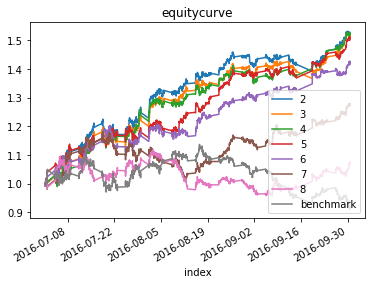

In [126]:
from Backtesting.Vectorized.models import OneContractTest

start = '20160701'
end = '20161001'
max_order=7
tcas = ['None']*max_order

test1 = OneContractTest(DATA_DIR, OUTPUT_DIR,slm)
test1.build('rb', '1610', max_order, freq, offset, start, end, tcas)

test1.run()
test1.plot()
test1.results[0]['benchmark'].plot()
plt.legend()
test1.performance

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
0,0.488262,0.024240,-0.003220,0.003186,0.000976,-0.015192,0.013452,-0.022867,0.989392,12.411182,149,1.145438,0.530201
1,0.445373,0.006237,-0.003287,0.003204,0.000214,-0.013452,0.015539,-0.062839,0.974729,3.500725,175,1.037419,0.365714
2,0.264400,0.002031,-0.003711,0.002941,0.000078,-0.011992,0.011949,-0.036529,0.792472,1.920556,156,1.012187,0.269231
3,0.276244,-0.001303,-0.003522,0.003012,-0.000045,-0.008478,0.013337,-0.054510,0.855333,-1.179568,175,0.992180,0.245714
4,0.348492,0.004130,-0.002822,0.003185,0.000116,-0.008900,0.009394,-0.032199,1.128440,2.962821,214,1.024780,0.210280
5,0.188459,0.007216,-0.002886,0.003535,0.000188,-0.009882,0.012476,-0.024638,1.225086,9.572494,230,1.043297,0.173913
6,0.129182,-0.014426,-0.003159,0.002317,-0.000446,-0.012476,0.009882,-0.107105,0.733458,-27.918539,194,0.913442,0.123711


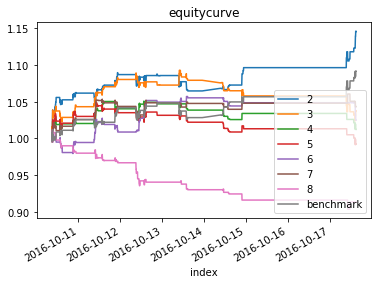

In [127]:
start = '20161001'
end = '20161231'
max_order=7
tcas = ['None']*max_order

test1 = OneContractTest(DATA_DIR, OUTPUT_DIR,slm)
test1.build('rb', '1610', max_order, freq, offset, start, end, tcas)

test1.run()

test1.plot()
test1.results[0]['benchmark'].plot()
plt.legend()
test1.performance

## Test on rb major contracts

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
0,0.450696,0.002036,-0.003336,0.00281,0.00005,-0.040607,0.028634,-0.117724,0.842291,1.129623,2421,1.122188,0.451466


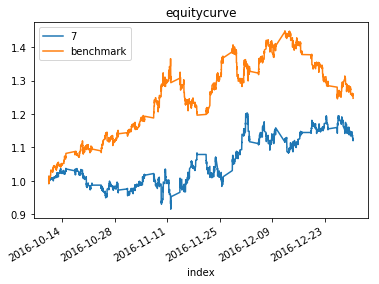

In [128]:
start = '20161001'
end = '20161231'
max_order=7
tcas = ['None']*max_order

test3 = MajorSeriesTest(df_bu_test, OUTPUT_DIR,slm)
test3.build( max_order, offset, start, end, tcas)

test3.run()

test3.plot()
test3.results[0]['benchmark'].plot()
plt.legend()
test3.performance

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
0,0.372717,0.002661,-0.002912,0.002473,0.000066,-0.040607,0.028634,-0.123962,0.84925,1.785174,5028,1.330021,0.445505


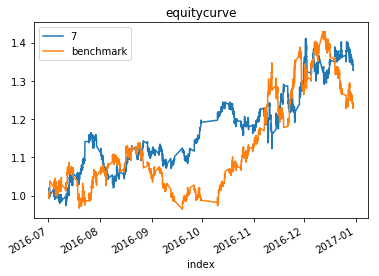

In [129]:
start = '20160601'
end = '20161231'
max_order=7
tcas = ['Fixed']*max_order

test4 = MajorSeriesTest(df_bu_test, OUTPUT_DIR,slm)
test4.build( max_order, offset, start, end, tcas)

test4.run()

test4.plot()
test4.results[0]['benchmark'].plot()
plt.legend()
test4.performance